In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import xgboost as xgb
from scipy.stats import randint, uniform
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, median_absolute_error, r2_score, make_scorer
from sklearn.utils import resample
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# import the data and  drop no longer needed columns
video_df = pd.read_csv("data/videos_prepared.csv")

remove_columns = ["video_id", "title", "channel_title"]
video_df.drop(columns=remove_columns, inplace=True)
video_df.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
0,0,0,6,11,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,20,4,4,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,18,3,10,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,19,0,11,1,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,20,2,10,0,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [3]:
# split into features and target variable & remove box cox view rate
X = video_df.drop(columns="box_view_rate")
y = video_df["box_view_rate"]

# split into training and test data
SEED = 666
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
50,0,11,0,11,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
309,0,19,1,9,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1,12,3,5,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
364,0,17,4,4,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
346,0,16,3,1,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
# load fitted lambda and back transform box cox test target values
with open("data/fitted_lambda.pkl", "rb") as f:
    fitted_lambda = pickle.load(f)

y_test_original = inv_boxcox(y_test, fitted_lambda)

In [5]:
# create custom scorer to minimize rmse in original units
def rmse_original_units(y_test, y_pred):
    y_test_bt = inv_boxcox(y_test, fitted_lambda)
    y_pred_bt = inv_boxcox(y_pred, fitted_lambda)
    return root_mean_squared_error(y_test_bt, y_pred_bt)

rmse_scorer = make_scorer(rmse_original_units, greater_is_better=False)

In [6]:
# hyperparameter tune a decision tree regressor
params = {"decisiontreeregressor__max_depth": [3, 5, 10, 15, 20, 30, None], "decisiontreeregressor__min_samples_leaf": [2, 4, 6], "decisiontreeregressor__min_samples_split": [2, 5, 10]}
dt_pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=SEED))
grid_search = GridSearchCV(dt_pipeline, param_grid=params, cv=10, scoring=rmse_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {-grid_search.best_score_}, best params: {best_params}")

best score: 558.6835361551704, best params: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 6, 'decisiontreeregressor__min_samples_split': 2}


In [7]:
# fit decision tree with optimal parameters
dt = DecisionTreeRegressor(max_depth=best_params["decisiontreeregressor__max_depth"], min_samples_leaf=best_params["decisiontreeregressor__min_samples_leaf"], min_samples_split=best_params["decisiontreeregressor__min_samples_split"], random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_original = inv_boxcox(y_pred, fitted_lambda)
box_rmse = round(root_mean_squared_error(y_test, y_pred), 2)
original_rmse = round(root_mean_squared_error(y_test_original, y_pred_original), 2)
medae = round(median_absolute_error(y_test_original, y_pred_original), 2)
print(f"box_rmse: {box_rmse}, original_rmse : {original_rmse}, medae: {medae}")

box_rmse: 1.89, original_rmse : 548.46, medae: 16.67


In [8]:
# calculate 95% confidence intervals
rmse_scores = []
medae_scores = []
for i in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_train), replace=True, random_state=i)
    y_resampled_pred = dt.predict(X_resampled)
    y_resampled_original = inv_boxcox(y_resampled, fitted_lambda)
    y_resampled_pred_original = inv_boxcox(y_resampled_pred, fitted_lambda)
    rmse = root_mean_squared_error(y_resampled_original, y_resampled_pred_original)
    medae = median_absolute_error(y_resampled_original, y_resampled_pred_original)
    rmse_scores.append(rmse)
    medae_scores.append(medae)

rmse_lower = np.percentile(rmse_scores, 2.5)
rmse_upper = np.percentile(rmse_scores, 97.5)
medae_lower = np.percentile(medae_scores, 2.5)
medae_upper = np.percentile(medae_scores, 97.5)
print(f"RMSE CI: [{round(rmse_lower, 2)}, {round(rmse_upper, 2)}], MedAE CI: [{round(medae_lower, 2)}, {round(medae_upper, 2)}]")

RMSE CI: [352.47, 717.42], MedAE CI: [11.72, 24.9]


In [9]:
# instantiate random forest and use randomized cross validation to search wide range of hyperparameters
params = {"randomforestregressor__n_estimators": [100, 200, 300, 500, 1000], "randomforestregressor__max_depth": [20, 30, 50, 60, None], "randomforestregressor__min_samples_leaf": [2, 4, 6],
          "randomforestregressor__max_features": ["sqrt", "log2", None], "randomforestregressor__bootstrap": [True, False]}
rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
rand_search = RandomizedSearchCV(rf_pipeline, param_distributions=params, cv=10, n_iter=50, scoring=rmse_scorer, n_jobs=-1, random_state=SEED)
rand_search.fit(X_train, y_train)
best_params = rand_search.best_params_
print(f"best score: {-rand_search.best_score_}, best params: {best_params}")

best score: 534.2997991062651, best params: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': 30, 'randomforestregressor__bootstrap': True}


In [10]:
# use gridsearch for fine-tuning hyperparameters
params = {"randomforestregressor__n_estimators": np.arange(best_params["randomforestregressor__n_estimators"] - 20, best_params["randomforestregressor__n_estimators"] + 30, 10),
          "randomforestregressor__max_depth": np.arange(best_params["randomforestregressor__max_depth"] - 5, best_params["randomforestregressor__max_depth"] + 10, 5),
          "randomforestregressor__min_samples_leaf": [best_params["randomforestregressor__min_samples_leaf"]], "randomforestregressor__max_features": [best_params["randomforestregressor__max_features"]],
          "randomforestregressor__bootstrap": [best_params["randomforestregressor__bootstrap"]]}
rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
grid_search = GridSearchCV(rf_pipeline, param_grid=params, cv=10, scoring=rmse_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {-grid_search.best_score_}, best params: {best_params}")

best score: 534.2997991062651, best params: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': np.int64(25), 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__n_estimators': np.int64(200)}


In [11]:
# fit random forest with optimal parameters
rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=best_params["randomforestregressor__n_estimators"], max_depth=best_params["randomforestregressor__max_depth"], min_samples_leaf=best_params["randomforestregressor__min_samples_leaf"],
                           max_features=best_params["randomforestregressor__max_features"], bootstrap=best_params["randomforestregressor__bootstrap"], random_state=SEED))
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
y_pred_original = inv_boxcox(y_pred, fitted_lambda)
box_rmse = round(root_mean_squared_error(y_test, y_pred), 2)
original_rmse = round(root_mean_squared_error(y_test_original, y_pred_original), 2)
medae = round(median_absolute_error(y_test_original, y_pred_original), 2)
r2 = round(r2_score(y_test_original, y_pred_original), 2)
rf = rf_pipeline.named_steps["randomforestregressor"]
print(f"box_rmse: {box_rmse}, original_rmse : {original_rmse}, medae: {medae}, r2: {r2}")

box_rmse: 1.52, original_rmse : 518.92, medae: 13.66, r2: 0.18


In [12]:
# calculate 95% confidence intervals
rmse_scores = []
medae_scores = []
for i in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_train), replace=True, random_state=i)
    y_resampled_pred = rf_pipeline.predict(X_resampled)
    y_resampled_original = inv_boxcox(y_resampled, fitted_lambda)
    y_resampled_pred_original = inv_boxcox(y_resampled_pred, fitted_lambda)
    rmse = root_mean_squared_error(y_resampled_original, y_resampled_pred_original)
    medae = median_absolute_error(y_resampled_original, y_resampled_pred_original)
    rmse_scores.append(rmse)
    medae_scores.append(medae)

rmse_lower = np.percentile(rmse_scores, 2.5)
rmse_upper = np.percentile(rmse_scores, 97.5)
medae_lower = np.percentile(medae_scores, 2.5)
medae_upper = np.percentile(medae_scores, 97.5)
print(f"RMSE CI: [{round(rmse_lower, 2)}, {round(rmse_upper, 2)}], MedAE: CI: [{round(medae_lower, 2)}, {round(medae_upper, 2)}]")

RMSE CI: [326.41, 684.91], MedAE: CI: [10.44, 15.51]


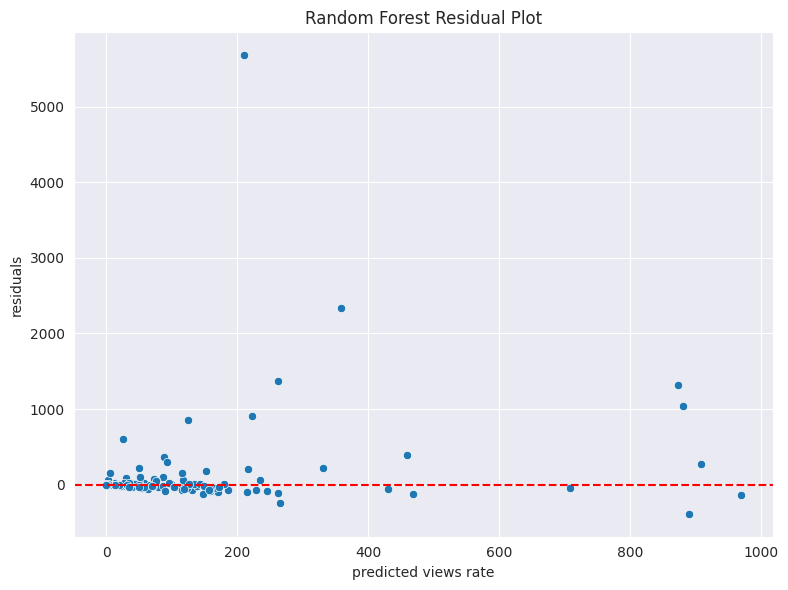

In [13]:
# visualize residuals to look for patterns
residuals = y_test_original - y_pred_original
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred_original, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted views rate")
plt.ylabel("residuals")
plt.title("Random Forest Residual Plot")
plt.tight_layout()

# save png
plt.savefig("images/rf_residual_plot.png", dpi=300)

In [16]:
# instantiate xgboost and use randomized cross validation to search wide range of hyperparameters
params = {"xgbregressor__n_estimators": randint(500, 900), "xgbregressor__max_depth": randint(5, 20), "xgbregressor__learning_rate": uniform(0.01, 0.3),
          "xgbregressor__colsample_bytree": uniform(0.5, 0.5), "xgbregressor__gamma": uniform(0, 5), "xgbregressor__reg_alpha": uniform(0, 1), "xgbregressor__reg_lambda": uniform(0, 1)}

xgb_pipeline = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED))
xgb_rand_search = RandomizedSearchCV(xgb_pipeline, param_distributions=params, cv=10, n_iter=50, scoring=rmse_scorer, n_jobs=-1, random_state=SEED)
xgb_rand_search.fit(X_train, y_train)
xgb_best_params = xgb_rand_search.best_params_
print(f"best score: {-xgb_rand_search.best_score_}, best params: {xgb_best_params}")

best score: 525.1149844741211, best params: {'xgbregressor__colsample_bytree': np.float64(0.8963200428343789), 'xgbregressor__gamma': np.float64(4.248481082882941), 'xgbregressor__learning_rate': np.float64(0.24752686230002538), 'xgbregressor__max_depth': 11, 'xgbregressor__n_estimators': 637, 'xgbregressor__reg_alpha': np.float64(0.7245150270453108), 'xgbregressor__reg_lambda': np.float64(0.7756212955821994)}


In [17]:
# use gridsearch for fine-tuning hyperparameters
params = {"xgbregressor__n_estimators": np.arange(xgb_best_params["xgbregressor__n_estimators"] - 80, xgb_best_params["xgbregressor__n_estimators"] + 100, 20),
          "xgbregressor__max_depth": [xgb_best_params["xgbregressor__max_depth"]], "xgbregressor__learning_rate": [xgb_best_params["xgbregressor__learning_rate"]],
          "xgbregressor__colsample_bytree": [xgb_best_params["xgbregressor__colsample_bytree"]], "xgbregressor__gamma": [xgb_best_params["xgbregressor__gamma"]],
          "xgbregressor__reg_alpha": [xgb_best_params["xgbregressor__reg_alpha"]], "xgbregressor__lambda": [xgb_best_params["xgbregressor__reg_lambda"]]}

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid=params, cv=10, scoring=rmse_scorer, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
xgb_best_params = xgb_grid_search.best_params_
print(f"best score: {-xgb_grid_search.best_score_}, best params: {xgb_best_params}")

best score: 525.1149844741211, best params: {'xgbregressor__colsample_bytree': np.float64(0.8963200428343789), 'xgbregressor__gamma': np.float64(4.248481082882941), 'xgbregressor__lambda': np.float64(0.7756212955821994), 'xgbregressor__learning_rate': np.float64(0.24752686230002538), 'xgbregressor__max_depth': 11, 'xgbregressor__n_estimators': np.int64(557), 'xgbregressor__reg_alpha': np.float64(0.7245150270453108)}


In [18]:
# fit xgboost with optimal parameters
xgb_pipeline = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED, n_estimators=xgb_best_params["xgbregressor__n_estimators"],
                                                                max_depth=xgb_best_params["xgbregressor__max_depth"], learning_rate=xgb_best_params["xgbregressor__learning_rate"],
                                                                colsample_bytree=xgb_best_params["xgbregressor__colsample_bytree"], gamma=xgb_best_params["xgbregressor__gamma"],
                                                                reg_alpha=xgb_best_params["xgbregressor__reg_alpha"], reg_lambda=xgb_best_params["xgbregressor__lambda"]))
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
y_pred_original = inv_boxcox(y_pred, fitted_lambda)
box_rmse = round(root_mean_squared_error(y_test, y_pred), 2)
original_rmse = round(root_mean_squared_error(y_test_original, y_pred_original), 2)
medae = round(median_absolute_error(y_test_original, y_pred_original), 2)
r2 = round(r2_score(y_test_original, y_pred_original), 2)
print(f"box_rmse: {box_rmse}, original_rmse : {original_rmse}, medae: {medae}, r2: {r2}")

box_rmse: 1.52, original_rmse : 519.54, medae: 12.22, r2: 0.18


In [19]:
# calculate 95% confidence intervals
rmse_scores = []
medae_scores = []
for i in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_train), replace=True, random_state=i)
    y_resampled_pred = xgb_pipeline.predict(X_resampled)
    y_resampled_original = inv_boxcox(y_resampled, fitted_lambda)
    y_resampled_pred_original = inv_boxcox(y_resampled_pred, fitted_lambda)
    rmse = root_mean_squared_error(y_resampled_original, y_resampled_pred_original)
    medae = median_absolute_error(y_resampled_original, y_resampled_pred_original)
    rmse_scores.append(rmse)
    medae_scores.append(medae)

rmse_lower = np.percentile(rmse_scores, 2.5)
rmse_upper = np.percentile(rmse_scores, 97.5)
medae_lower = np.percentile(medae_scores, 2.5)
medae_upper = np.percentile(medae_scores, 97.5)
print(f"RMSE CI: [{round(rmse_lower, 2)}, {round(rmse_upper, 2)}], MedAE: CI: [{round(medae_lower, 2)}, {round(medae_upper, 2)}]")

RMSE CI: [329.84, 683.8], MedAE: CI: [9.3, 15.4]


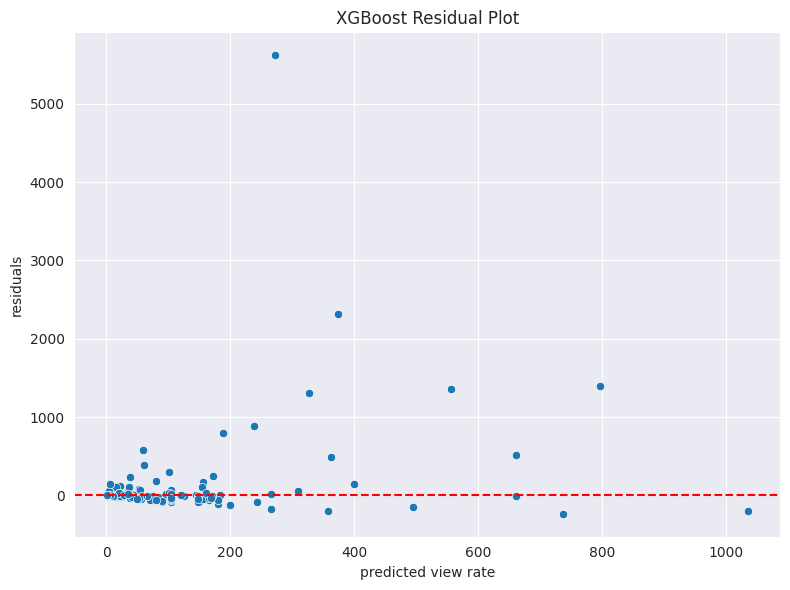

In [20]:
# visualize residuals to look for patterns
residuals = y_test_original - y_pred_original
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred_original, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted view rate")
plt.ylabel("residuals")
plt.title("XGBoost Residual Plot")
plt.tight_layout()

# save png
plt.savefig("images/xgb_residual_plot.png", dpi=300)

In [33]:
# save data and model pipelines
X_test.to_csv("data/x_test.csv")
X_train.to_csv("data/x_train.csv")
residuals.to_csv("data/residuals.csv")
with open("data/pipelines.pkl", "wb") as f:
    pickle.dump((rf_pipeline, xgb_pipeline), f)